# Judge Hiciano Jupyter Notebook

In [23]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix

#import machine learning related libraries
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [39]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv") 
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [26]:
df_train.describe()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,...,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,ordered
count,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,426248.000000,426248.000000,426248.000000,429013.000000,423883.000000,...,237680.000000,277915.000000,275273.000000,275273.000000,275273.000000,277915.000000,277617.000000,277915.000000,277915.000000,429013.000000
mean,25274.631293,14.617061,5.924839,1573.901640,24.140317,55.289127,146.663005,1189.248209,4.135168,67.625341,...,2.292393,12184.130921,2486.358270,485.298449,135.557403,15.218016,44.919861,1.734556,79.883975,0.676040
std,14441.366146,4.485914,0.790930,2427.123356,30.398164,148.879937,283.217841,3371.173815,4.451778,174.986371,...,1.306963,7297.774184,3038.425813,131.027630,109.577139,34.892917,11.935945,0.443903,113.201967,0.467985
min,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,17.000000,1.000000,3.000000,0.000000
25%,12731.000000,11.000000,5.000000,225.070000,5.000000,6.990000,25.950000,137.960000,1.000000,8.990000,...,1.000000,5793.000000,600.000000,481.000000,43.000000,3.000000,36.000000,1.000000,14.000000,0.000000
50%,25470.000000,15.000000,6.000000,738.199000,13.000000,12.000000,49.990000,388.000000,3.000000,14.990000,...,2.000000,12045.000000,1500.000000,520.000000,109.000000,8.000000,45.000000,2.000000,34.000000,1.000000
75%,37542.000000,18.000000,7.000000,1880.265000,31.000000,29.990000,99.990000,1046.430000,5.000000,34.990000,...,3.000000,18350.000000,4000.000000,555.000000,219.000000,15.000000,53.000000,2.000000,86.000000,1.000000
max,50000.000000,23.000000,7.000000,21580.092000,200.000000,5999.990000,6999.990000,115742.000000,108.000000,6999.990000,...,5.000000,25038.000000,50000.000000,638.000000,600.000000,868.000000,99.000000,3.000000,738.000000,1.000000


In [27]:
df_train.head()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,...,customerID,purchase,score,account,payments,age,salutation,lastOrder,order,ordered
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1


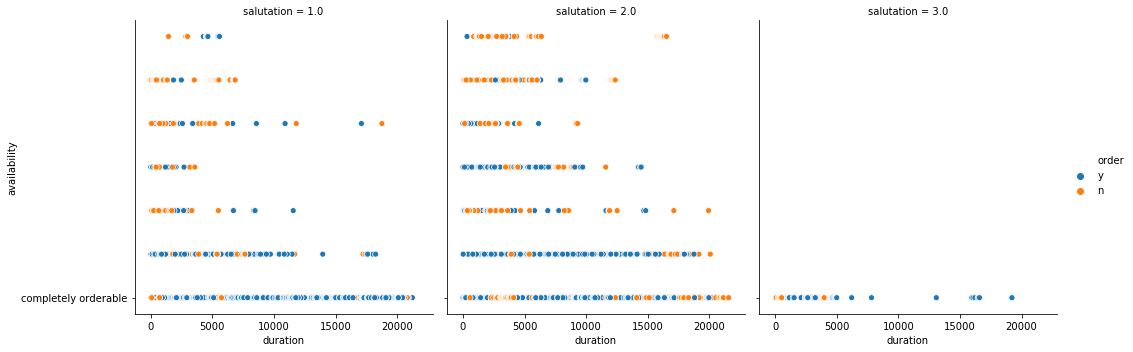

In [28]:
sns.relplot(x="duration", y="availability", col="salutation",
            hue="order", #, style="smoker", size="order",
            data=df_train);

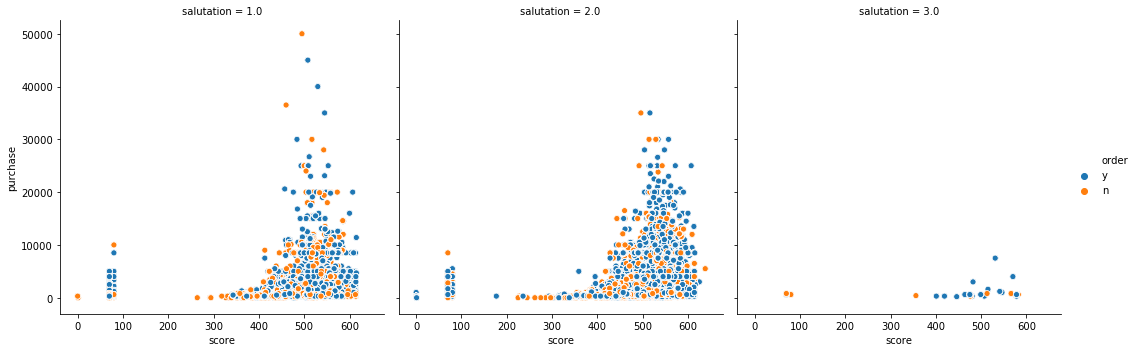

In [29]:
sns.relplot(x="score", y="purchase", col="salutation",
            hue="order", #, style="smoker", size="order",
            data=df_train);

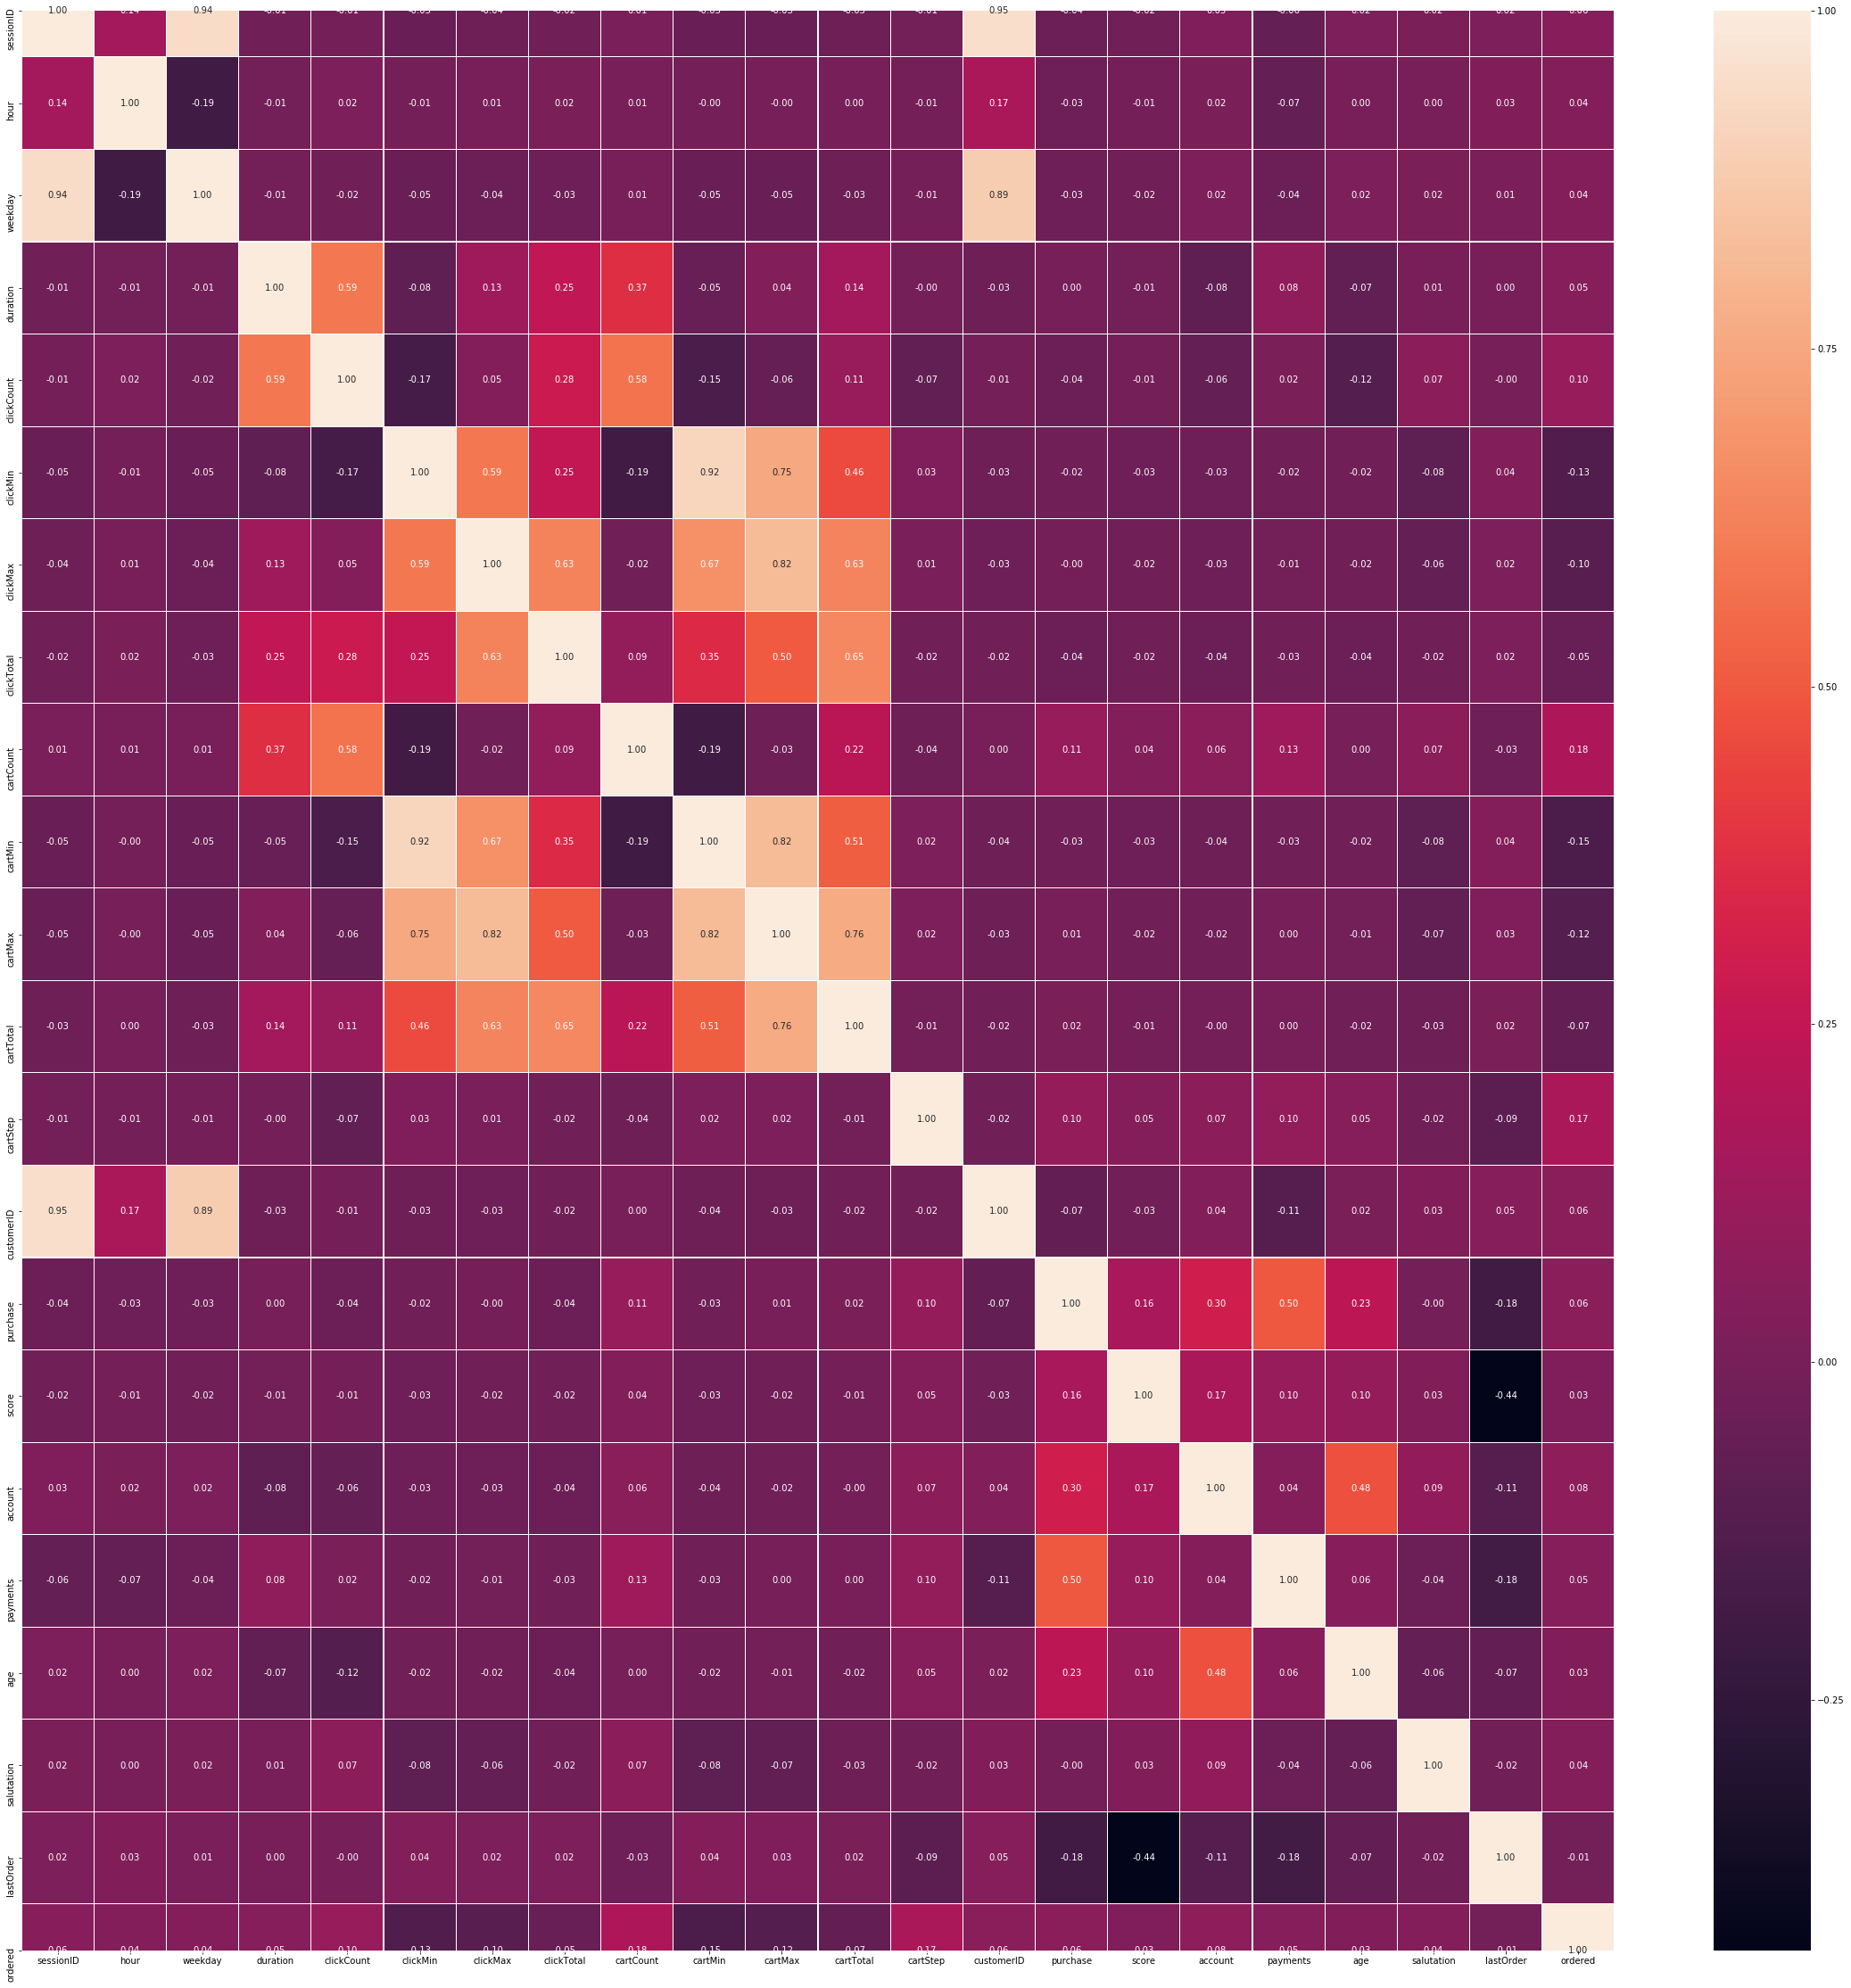

In [30]:
corr = df_train[df_train.columns].corr()
plt.figure(figsize = (40,40))
sns.heatmap(corr, annot = True, linewidths=0.1, fmt=".2f");

In [45]:
df_train = pd.get_dummies(df_train)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
df_train.head()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,ordered,status_n,status_y,availability_completely not determinable,availability_completely not orderable,availability_completely orderable,availability_mainly not determinable,availability_mainly not orderable,availability_mainly orderable,availability_mixed,order_n,order_y
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,0,1,0,0,1,0,0,0,0,0,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,0,1,0,0,1,0,0,0,0,0,1
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0,1,0,0,0,0,0,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0,1,0,0,0,0,0,1


In [51]:
df_train =pd.DataFrame(df_train).fillna(0)
X, y = df_train.drop(['order_n','order_y'],axis=1), df_train.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [ ]:

#create an array of models as base to see what has highest base score to select for tuning
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

LR [0.71277643 0.71115643]
NB [0.83301186 0.82975438]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF [1. 1.]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)